In [1]:
!pip install imgaug                     # for image augmentation

In [2]:
!pip install -U segmentation-models    # ONLY used for dice metric and IOU metric computation, models are made from scratch

     |████████████████████████████████| 51kB 6.1MB/s 


In [3]:
!pip install plot-metric                 # ONLY used for ROC curve, confusion matrix plotting

In [4]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.utils import class_weight

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
GPU is available


In [5]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
from keras.utils import generic_utils
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [6]:
os.environ['KAGGLE_USERNAME'] = "kanishkapandey" # username from the json file
os.environ['KAGGLE_KEY'] = "76240e9e3c518a7d0844f07ba6617476" # key from the json file

In [7]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 98% 1.02G/1.03G [00:27<00:00, 31.6MB/s]
100% 1.03G/1.03G [00:27<00:00, 40.6MB/s]


In [8]:
os.listdir()

['.config', 'covid19-ct-scans.zip', 'sample_data']

In [9]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [10]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
1,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
2,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
3,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
4,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [11]:
raw_data.shape

(20, 4)

In [12]:
img_size = 512

In [13]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

In [14]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)

  # super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

* Dataset contain 20 files of .nii type, though each file contained multiple channels or silces each as a separate gray scale image.
* Total slices are 3520. These have been sliced out by 20% in the front and by 20% in the last of each file since in general these didn't had any infection masks and some didn't had the lungs, removed as noise.
* Also, images had pixel values from -998 to 1000+. Did min-max scaling.

In [15]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [16]:
all_points1 = []
all_points2 = []

In [17]:
def read_nii(filepath, data, string):
    '''
    Reads .nii file and returns pixel array

    '''
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    #print(array.shape[2])
    #array = skimage.transform.resize(array, (array.shape[2], img_size, img_size))
    #array = cv2.resize(array, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    

    if string == "lungs":
      all_points1 = []
      all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
          continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, points1, points2 = cropper(img, demo = 0)
          all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          all_points2.append((points2[0], points2[1], points2[2], points2[3]))
          continue 

        if string == "cts" and img_no < len(all_points1):
          img = clahe_enhancer(img, demo = 0)
          # img, points1, points2 = cropper(img, demo = 0)
          # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          # all_points2.append((points2[0], points2[1], points2[2], points2[3]))   
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

        if string == "infections" and img_no < len(all_points1):
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)


        # img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
        # img = img/255
        #  remember to normalize again
        # also resize images and masks for all
        
        data.append(img)

In [18]:
cts = []
lungs = []
infections = []

In [19]:
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


(250, 250) (250, 250)


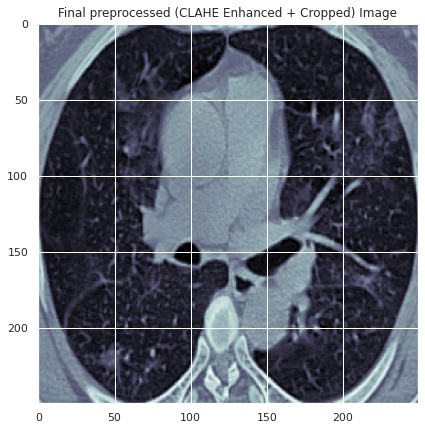

In [20]:
x = 120

rcParams['figure.figsize'] = 7, 7

plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

print(infections[x].shape, cts[x].shape)

* Also, figuring out that 498 slices were of complete black masks i.e. no infection. For right now, kept out as didn't want to bother the segmentation model with this. 
* A better approach would be to make a sub-task and use that sub-task's output as input in our main task. Train a separate binary classifier to classify the CT scan as complete black or not, then the not ones to be passed from the segmentation model trained in this notebook.

In [21]:
#new
y_label = []
for i in range(0, len(infections)):
  if len(np.unique(infections[i]))!=1:
    y_label.append(1)
  else:
    y_label.append(0)

In [22]:
#new
print(y_label.count(0), y_label.count(1))

497 1615


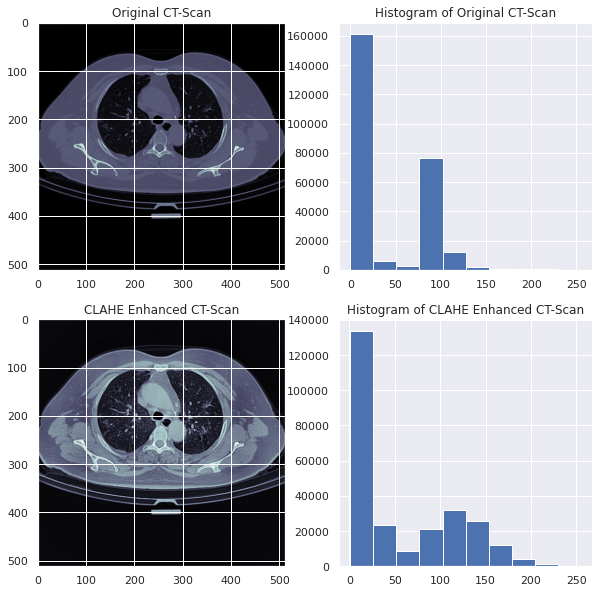

In [23]:
test_file = []
read_nii_demo(raw_data.loc[0,'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[155], demo = 1)

* A demo for the cropped images, notice how the unwanted part including the diaphragm got cut

In [24]:
# test_mask = []
# read_nii_demo(raw_data.loc[0,'infection_mask'], test_mask)
# test_mask = np.array(test_mask)
# test_mask = np.uint8(test_mask*255)
# rcParams['figure.figsize'] = 10,10
# plt.imshow(test_mask[120][20:155, 4:217], cmap = 'bone')
# test_mask[120][20:155, 4:217].shape

In [25]:
print(len(cts) , len(infections))

2112 2112


In [26]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
  dim1.append(cts[i].shape[0])
  dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))

An idea about the new net dimension to which all must be resized to (some will increase and some decrease) ---> 250.0 x 250.0


In [27]:
# 32*11 = 352

In [28]:
new_dim = 224

In [29]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)

In [30]:
# for i in range(0, len(cts)):
#   cts[i] = cv2.cvtColor(cts[i], cv2.COLOR_GRAY2RGB)

In [31]:
cts = np.array(cts)
cts = cts.reshape(len(cts), new_dim,new_dim,1)
y_label = np.array(y_label)
print(cts.shape, y_label.shape)

(2112, 224, 224, 1) (2112,)


In [32]:
# from keras.utils.np_utils import to_categorical
# y_label = to_categorical(y_label, 2)

* Saving the numpy arrays to later reuse the same preprocessing for other models rather than doing it again and again.

* Using joblib which is way faster to dump and load than numpy and other techniques. Refer to the benchmarks:
 http://gael-varoquaux.info/programming/new_low-overhead_persistence_in_joblib_for_big_data.html

In [33]:
# import joblib
# joblib.dump(cts, 'cts_192.pkl')

In [ ]:
# No Augmentation added this time

* Normalizing images and masks from 0 to 1

In [34]:
cts = cts/255

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(cts, y_label):
  x_train, x_valid = cts[train_index], cts[test_index]
  y_train, y_valid = y_label[train_index], y_label[test_index]
# x_train, x_valid, y_train, y_valid = StratifiedShuffleSplit(cts, y_label, test_size=0.3, random_state=42, stratify=True)

In [37]:
np.unique(y_label, return_counts=True)

(array([0, 1]), array([ 497, 1615]))

In [38]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([ 348, 1130]))

In [39]:
np.unique(y_valid, return_counts=True)

(array([0, 1]), array([149, 485]))

In [56]:
print(x_train.shape, x_valid.shape)
print(y_train.shape, y_valid.shape)

(1478, 224, 224, 1) (634, 224, 224, 1)
(1478,) (634,)


In [93]:
y_label.shape

(2112,)

In [57]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_t = precision(y_true, y_pred)
    recall_t = recall(y_true, y_pred)
    return 2*((precision_t*recall_t)/(precision_t+recall_t+K.epsilon()))


class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        global best_val_auc
        global model
        y_pred_train = self.model.predict_proba(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict_proba(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        if best_val_auc < roc_val:
          best_val_auc = roc_val
          model.save_weights('best_val_auc_weights.h5')
          print("Saving best validation AUC weights")
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [58]:
from keras.models import Sequential
from keras.layers import Flatten
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", kernel_initializer="he_normal", input_shape=(new_dim,new_dim,1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding="same", activation='relu' , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same", activation='relu' , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", activation='relu' , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
# model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
# model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))             
model.add(Dense(1 , activation='sigmoid'))      

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 16)      160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_14 (Batc (None, 112, 112, 32)     

In [59]:
# import math
# def step_decay(epoch):
#     initial_lrate = 0.0008
#     drop = 0.8
#     epochs_drop = 10
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     print('New learning rate', lrate)
#     return lrate

# lrate = LearningRateScheduler(step_decay)

In [60]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
print(weights)

[2.12356322 0.6539823 ]


In [61]:
weight={0:weights[0],1:weights[1]}
print(weight)

{0: 2.1235632183908044, 1: 0.6539823008849558}


In [62]:
from sklearn.metrics import roc_auc_score
batch_size = 32
epochs = 25
best_val_auc = -1
roc = RocCallback(training_data=(x_train, y_train),
                  validation_data=(x_valid, y_valid))

#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
# filepath_auc="covid_weights_aucroc.hdf5"
filepath_loss = "covid_weights_val_loss.hdf5"
# filepath_acc = "covid_weights_val_acc.hdf5"
# checkpoint_auc = ModelCheckpoint(filepath_auc, monitor='roc-auc_val', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# checkpoint_acc = ModelCheckpoint(filepath_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [63]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=[f1])

In [64]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid) ,
                    callbacks = [roc, checkpoint_loss], class_weight=weight)

Epoch 1/25
roc-auc_train: 0.6783 - roc-auc_val: 0.6595                                                                                                    
Saving best validation AUC weights

Epoch 00001: val_loss improved from inf to 0.72578, saving model to covid_weights_val_loss.hdf5
47/47 [==============================] - 4s 78ms/step - loss: 0.9809 - f1: 0.8045 - val_loss: 0.7258 - val_f1: 0.7297
Epoch 2/25
roc-auc_train: 0.6903 - roc-auc_val: 0.6845                                                                                                    
Saving best validation AUC weights

Epoch 00002: val_loss did not improve from 0.72578
47/47 [==============================] - 3s 68ms/step - loss: 0.4251 - f1: 0.8479 - val_loss: 1.9082 - val_f1: 0.0862
Epoch 3/25
roc-auc_train: 0.843 - roc-auc_val: 0.805                                                                                                    
Saving best validation AUC weights

Epoch 00003: val_loss improved from 0.72578 to

* Model saved in json format and its weight in .hdf5 format at local

In [65]:
gc.collect()

10358

In [66]:
# model.load_weights(filepath_loss)
model.load_weights("best_val_auc_weights.h5")

In [67]:
model.save_weights('best_val_auc_weights.h5')

In [68]:
files.download('best_val_auc_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
model_json = model.to_json()
with open("best_val_auc_weights.json","w") as json_file:
     json_file.write(model_json)

files.download("best_val_auc_weights.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
print("Best saved AUCROC on validation set :" , best_val_auc)

Best saved AUCROC on validation set : 0.9982979312253512


In [71]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss:" , score[0], "\ntest f1 score:" , score[1])

20/20 [==============================] - 0s 13ms/step - loss: 0.0479 - f1: 0.9854
test loss: 0.04794909805059433 
test f1 score: 0.9853617548942566


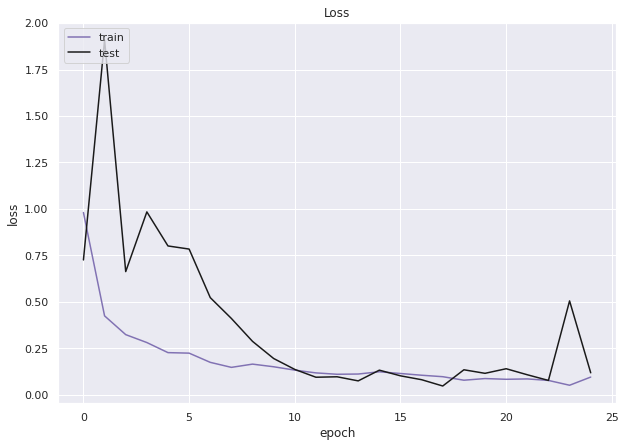

In [72]:
rcParams['figure.figsize'] = 10,7
plt.grid('True')
plt.plot(results.history['loss'], color='m')
plt.plot(results.history['val_loss'], color='k')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
predictions = model.predict(x_valid)
predictions = np.array(predictions.flatten())
#print(predictions)

In [108]:
#(y_valid)

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

In [110]:
y_pred=np.where(predictions>0.5,1,0)

In [111]:
print(roc_auc_score(y_valid,y_pred))

0.9739431259946033


In [98]:
#for i in range(0,6):
#  if(predictions[i]>=0.5):
#    print("covid +ve")
#  else:
#    print("covid -ve")
#  print(x_valid[i][0][0][0])

covid +ve
0.5529411764705883
covid +ve
0.01568627450980392
covid -ve
0.1843137254901961
covid +ve
0.611764705882353
covid +ve
0.5058823529411764
covid +ve
0.0784313725490196


In [116]:
fpr,tpr,thresholds=sklearn.metrics.roc_curve(y_valid,y_pred,pos_label=1)
random_probs=[0 for i in range(len(y_valid))]
p_fpr, p_tpr, _ = sklearn.metrics.roc_curve(y_valid, random_probs, pos_label=1)

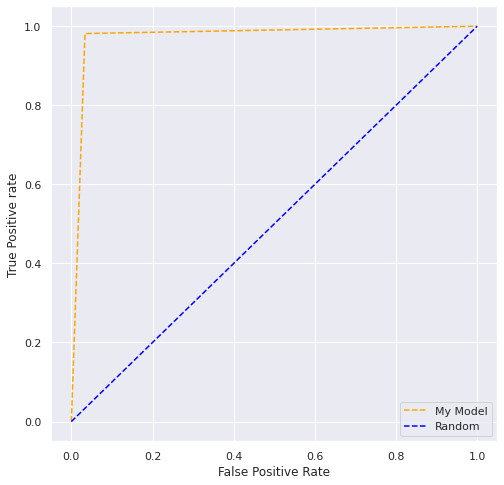

In [117]:
rcParams['figure.figsize'] = 8,8
plt.plot(fpr, tpr, linestyle='--',color='orange', label='My Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

,True Class,Predicted Proba,Predicted Type,Predicted Class
0,1,1.000000e+00,TP,Class 1
1,1,9.999988e-01,TP,Class 1
2,0,4.519556e-01,TN,Class 0
3,1,9.998054e-01,TP,Class 1
4,1,9.991432e-01,TP,Class 1
...,...,...,...,...
629,0,2.458631e-15,TN,Class 0
630,1,9.997963e-01,TP,Class 1
631,1,9.967187e-01,TP,Class 1
632,0,6.579211e-01,FP,Class 1


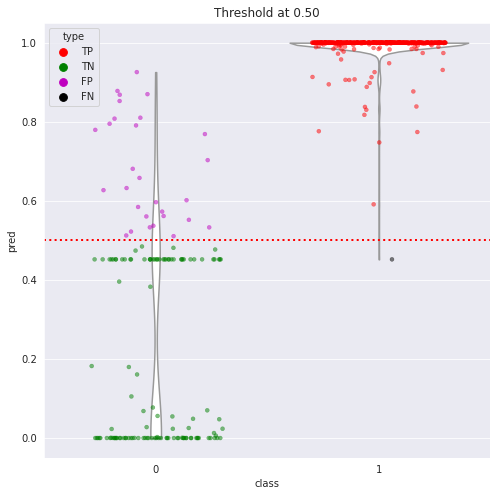

In [ ]:
bc1.plot_class_distribution(threshold = 0.5, pal_colors=['r','g','m','k'])

Accuracy: 0.9526813880126183
Precision: 0.9434697855750487
Recall: 0.9979381443298969
F1 score: 0.969939879759519


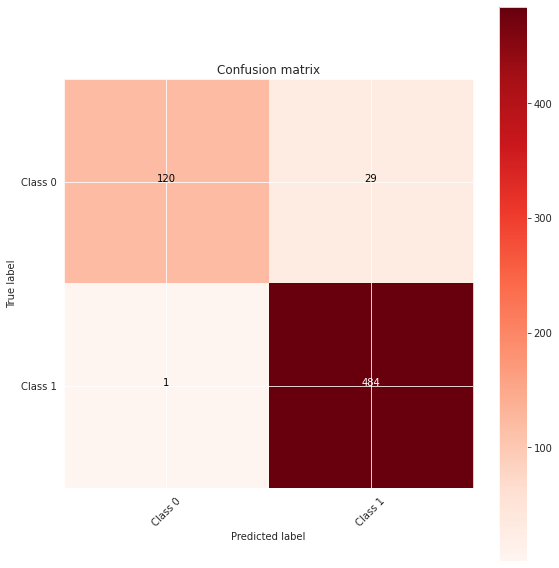

In [ ]:
a = bc1.plot_confusion_matrix()
tn = a[0][0]
fp = a[0][1]
fn = a[1][0]
tp = a[1][1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print('Accuracy:', (tp+tn)/(tp+tn+fp+fn))
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', 2*precision*recall/(precision+recall))

In [ ]:
bc2 = BinaryClassification(y_valid, predictions, labels=["Class 0", "Class 1"], threshold = 0.81)

0.9981664706289353

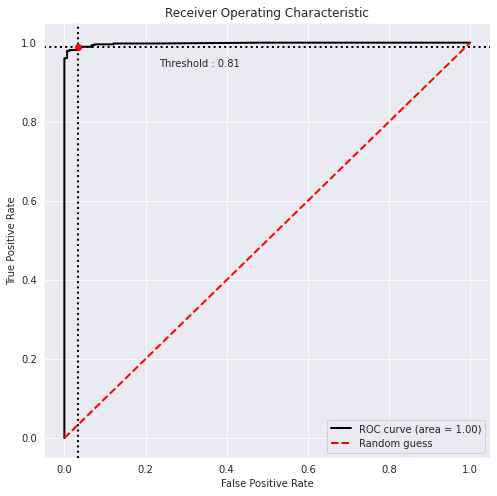

In [ ]:
bc2.plot_roc_curve()[3]

,True Class,Predicted Proba,Predicted Type,Predicted Class
0,1,1.000000e+00,TP,Class 1
1,1,9.999988e-01,TP,Class 1
2,0,4.519556e-01,TN,Class 0
3,1,9.998054e-01,TP,Class 1
4,1,9.991432e-01,TP,Class 1
...,...,...,...,...
629,0,2.458631e-15,TN,Class 0
630,1,9.997963e-01,TP,Class 1
631,1,9.967187e-01,TP,Class 1
632,0,6.579211e-01,TN,Class 0


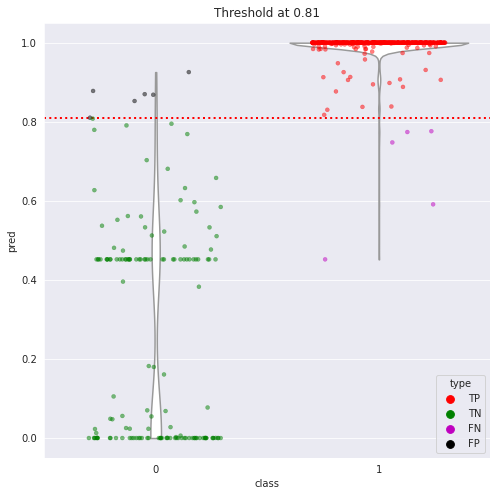

In [ ]:
bc2.plot_class_distribution(threshold = 0.81, pal_colors=['r','g','m','k'])

Accuracy: 0.9826498422712934
Precision: 0.9876543209876543
Recall: 0.9896907216494846
F1 score: 0.9886714727085478


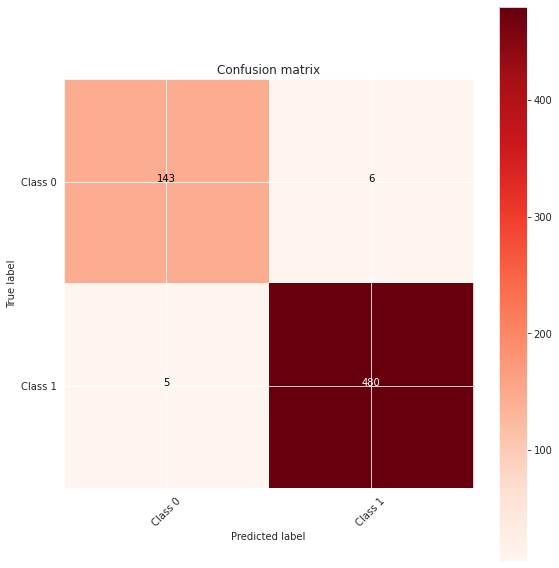

In [ ]:
b = bc2.plot_confusion_matrix()
tn = b[0][0]
fp = b[0][1]
fn = b[1][0]
tp = b[1][1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print('Accuracy:', (tp+tn)/(tp+tn+fp+fn))
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', 2*precision*recall/(precision+recall))

In [ ]:
gc.collect()

106694